In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
DAY=1

In [3]:
dim=(54, 4100, 1704)
def shuffle_XY(idx_date,idx_item,idx_store,X,y):
    idx=np.random.permutation(range(len(y)))
    return idx_date[idx],idx_item[idx],idx_store[idx], X[idx],y[idx]
def get_series(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b

In [4]:
def convert_nan(X):
    idx=np.isnan(X)
    X[idx]=0
    newx=np.concatenate([X,idx],axis=1)
    newx=newx.astype(np.float16,copy=False)
    return newx
def read_data(day):
    print "read data for day", day
    dirname='../input/d'+str(day)+"/"
    y=get_series('y_0')
    cols=np.load(dirname+"cols"+".npy")
    train_test=np.load(dirname+"train_test"+".npy")
    print "loaded", y.shape,train_test.shape 
    return cols,train_test,y.astype(np.float16)

In [5]:
%time cols,train_test,y=read_data(DAY)
rawy=y

read data for day 1
loaded (54, 4100, 1704) (37, 54, 4100, 1704)
CPU times: user 4.76 s, sys: 26.2 s, total: 31 s
Wall time: 1min 46s


In [6]:
print "types", [u.dtype for u in (cols, train_test, y)]
print "shapes", [u.shape for u in (cols, train_test, y)]
print "mem(gb)",np.round(train_test.nbytes/1024.**3,2), np.round(y.nbytes/1024.**3,2)

types [dtype('S37'), dtype('float16'), dtype('float16')]
shapes [(37,), (37, 54, 4100, 1704), (54, 4100, 1704)]
mem(gb) 26.0 0.7


In [7]:
train_test=np.rollaxis(train_test,0,4)
print "rolled train_test shape", train_test.shape

rolled train_test shape (54, 4100, 1704, 37)


In [8]:
gc.collect()

12

In [9]:
def show_data(store,item,date):
    thisy=y[store,item,date-10:date+10]
    a=train_test[store,item,date-10:date+10,:]
    a=np.squeeze(a)
    print a.shape
    df=pd.DataFrame(a,columns=cols,index=range(date-10,date+10))
    df['target']=thisy
    with pd.option_context('display.max_columns', None):
        display(df)

In [10]:
#show_data(0,1000,1688)

# cv

In [11]:
def make_data(low,high):
    y_train=y[:,:,low:high]
    X_train=train_test[:,:,low:high,:]
    ind=~np.isnan(y_train)
    a,b=X_train[ind],y_train[ind]
    #a=a.astype(np.float32,copy=False)
    #b=b.astype(np.float32,copy=False)
    print a.shape,b.shape,a.dtype,b.dtype
    return a,b 

In [12]:
X,y=make_data(100,1688)

(121371519, 37) (121371519,) float16 float16


In [13]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [14]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [15]:
print K.floatx()

float32


In [16]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.intra_op_parallelism_threads=8
config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [17]:
input_dim=X.shape[1]
input_dim

37

In [18]:
class TransformNALayer(Layer):

    def __init__(self,   **kwargs):
        super(TransformNALayer, self).__init__(**kwargs)
        self.supports_masking = True
    def build(self, input_shape):
        super(TransformNALayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x,training=None):
        def make_na(x):
            ind=tf.is_nan(x)
            filled_x=tf.where(ind, tf.zeros_like(x,dtype=np.float32), x)
            ind=tf.cast(ind,tf.float32)
            filled_x=tf.cast(filled_x,tf.float32)
            return  tf.cast(tf.concat([filled_x,ind],axis=1),tf.float32)
        def add_dropout(x):
            def f(x):
                ind=tf.random_uniform([1,37])<tf.random_uniform([1])[0]/tf.constant(5.0)
                ind2=tf.cast(ind,tf.float32)*tf.ones_like(x)
                newx=tf.where(ind2>0,tf.constant(np.nan,dtype=tf.float32)*tf.ones_like(x), x)
                return newx
            return tf.cond(tf.random_uniform([1])[0]>tf.constant(0.5),lambda: f(x),lambda : x)
        return K.in_train_phase(make_na(add_dropout(x)),make_na(x),training=training)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*2)        

In [19]:
X.shape

(121371519, 37)

In [20]:
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [21]:
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 1.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   print "set learning rate to",lrate
   return lrate
lrate = keras.callbacks.LearningRateScheduler(step_decay)

In [22]:
#plt.plot([step_decay(u) for u in range(5)])

In [24]:
class KerasModel:
    def __init__(self,params={}):
        self.params=params
        self.model=None
    def _make_model(self):
        params=self.params
        model = Sequential()
        model.add(InputLayer(input_shape=params['input_dim']))
        model.add(TransformNALayer())
        for sz in params["hidden_layer_sizes"]:
            if params['batch_normalization']:
                model.add(BatchNormalization())
            model.add(Dense(sz,kernel_regularizer=regularizers.l2(params['l2'])))
            model.add(Dropout(params['dropout_rate']))            
            model.add(Activation(params['activation']))
        if params['loss'] == 'mean_squared_error':
            model.add(Dense(1,activation=None))
            this_loss="mean_absolute_error"
            if params['metric']=="mean_squared_error":
                this_metrics=['mean_squared_error']
            else:
                raise Exception("unknown")
        else:
            raise Exception("unknown")
        model.compile(optimizer=params['optimizer'],
          loss=this_loss,
                    #  metrics=None)
          metrics=this_metrics)

        self.model=model
        return self
    def fit(self,X,y):
        params=self.params
        validation_split=params['validation_split']
        patience=params['patience']
        if self.model is None:
            self._make_model()
        metric_name=self.model.metrics_names[-1]
        #print "earlystopping on "+metric_name
        #self.name='day'+str(DAY)+'_adam.{epoch:02d}-{val_loss:.3f}.h5'
        self.name='day'+str(DAY)+'_adam_mae.h5'
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        checkpoint = keras.callbacks.ModelCheckpoint(self.name, monitor='val_loss', 
                                                     verbose=1, 
                                                     save_best_only=True, 
                                                     save_weights_only=False, 
                                                     mode='auto', period=1)        
        batch_size=params['batch_size']
        self.hist=self.model.fit(X, y, batch_size=batch_size,epochs=200, 
                       validation_split=validation_split, 
                       #validation_data=(X_valid,y_valid),
                       callbacks=[early_stopping,checkpoint],verbose=1)
        return self
    def load_best(self):
        return keras.models.load_model(self.name,
                                       custom_objects={'TransformNALayer':TransformNALayer})
    

In [25]:
param_grid={'input_dim':[(input_dim,)],
            'batch_size':[1024],
            'hidden_layer_sizes': [(256,256),()],
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "validation_split":[0.1],"patience":[3],
            "dropout_rate":[0.0],
            "activation":['relu'],    
            "l2":[1e-6,0],
            "epsilon":[0.1],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
len(parameters)

12

In [26]:
parameter=parameters[0]
parameter

{'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 1024,
 'dropout_rate': 0.0,
 'epsilon': 0.1,
 'hidden_layer_sizes': (256, 256),
 'input_dim': (37,),
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3,
 'validation_split': 0.1}

In [27]:
def run_once(parameter):
    backend.clear_session()
    set_session(tf.Session(config=config))
    a=KerasModel(parameter)
    a._make_model()
    h=a.fit(X,y)
    return [parameter,h.history]

In [28]:
if 0:
    backend.clear_session()
    set_session(tf.Session(config=config))    
    a=KerasModel(parameter)
    a._make_model()
    from IPython.display import SVG
    from keras.utils.vis_utils import model_to_dot
    for l in a.model.layers:
        print l, l.input_shape 
    display(SVG(model_to_dot(a.model).create(prog='dot', format='svg')))
   

In [29]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=KerasModel(parameter)
a._make_model()

<__main__.KerasModel instance at 0x7f6b6ce965f0>

In [30]:
a.params

{'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 1024,
 'dropout_rate': 0.0,
 'epsilon': 0.1,
 'hidden_layer_sizes': (256, 256),
 'input_dim': (37,),
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3,
 'validation_split': 0.1}

In [31]:
a.fit(X,y)

Train on 109234367 samples, validate on 12137152 samples
Epoch 1/200
109234367/109234367 [==============================] - 813s 7us/step - loss: 0.3940 - mean_squared_error: 0.2652 - val_loss: 0.3932 - val_mean_squared_error: 0.2668
Epoch 2/200
109234367/109234367 [==============================] - 809s 7us/step - loss: 0.3908 - mean_squared_error: 0.2627 - val_loss: 0.3925 - val_mean_squared_error: 0.2655
Epoch 3/200
109234367/109234367 [==============================] - 762s 7us/step - loss: 0.3902 - mean_squared_error: 0.2622 - val_loss: 0.3919 - val_mean_squared_error: 0.2652
Epoch 4/200
109234367/109234367 [==============================] - 765s 7us/step - loss: 0.3899 - mean_squared_error: 0.2619 - val_loss: 0.3914 - val_mean_squared_error: 0.2641
Epoch 5/200
109234367/109234367 [==============================] - 803s 7us/step - loss: 0.3897 - mean_squared_error: 0.2617 - val_loss: 0.3910 - val_mean_squared_error: 0.2646
Epoch 6/200
109234367/109234367 [=========================

KeyboardInterrupt: 

In [32]:
XX=X[-1000000:]
yy=y[-1000000:]

In [33]:
from sklearn.metrics import mean_squared_error
amodel=a.model
yy_pred1=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred1)

0.26049691

In [34]:
from sklearn.metrics import mean_squared_error
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
yy_pred1=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred1)

0.26087642

In [ ]:
train_test.shape

(54, 4100, 1704, 37)

In [ ]:
from sklearn.metrics import mean_squared_error
lst=[]
lst2=[]
lst3=[]
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in range(1500,1688):
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    ay=rawy[:,:,i].reshape(-1)
    yy_pred3=amodel.predict(ax,4096)[:,0]
    lst.append(yy_pred3.reshape(rawy.shape[:2]))
    lst2.append(~np.isnan(rawy[:,:,i]))
    lst3.append(rawy[:,:,i])
    print i,mean_squared_error(ay[~np.isnan(ay)],yy_pred3[~np.isnan(ay)])

1500 0.253969
1501 0.252675
1502 0.244898
1503 0.249176
1504 0.261486
1505 0.270406
1506 0.247935
1507 0.259508
1508 0.252243
1509 0.252591
1510 0.260776
1511 0.252159
1512 0.243079
1513 0.252467
1514 0.247666
1515 0.263462
1516 0.275208
1517 0.282097
1518 0.27099
1519 0.272843
1520 0.266448
1521 0.257869
1522 0.251392
1523 0.268647
1524 0.268192
1525 0.263201
1526 0.254267
1527 0.255864
1528 0.265797
1529 0.259514
1530 0.247617
1531 0.252623
1532 0.248196
1533 0.24356
1534 0.239708
1535 0.248712
1536 0.246121
1537 0.239923
1538 0.247758
1539 0.243946
1540 0.241122
1541 0.24406
1542 0.264607
1543 0.252742
1544 0.250987
1545 0.254264
1546 0.244572
1547 0.255851
1548 0.243596
1549 0.261262
1550 0.253732
1551 0.342304
1552 0.268634
1553 0.293671
1554 0.256908
1555 0.252239
1556 0.249815
1557 0.252858
1558 0.249218
1559 0.253053
1560 0.254051
1561 0.254525
1562 0.270888
1563 0.281456
1564 0.27517
1565 0.246848
1566 0.24353
1567 0.258764
1568 0.2508
1569 0.253141
1570 0.264268
1571 0.257969

In [38]:
lst=np.array(lst)
lst2=np.array(lst2)
lst3=np.array(lst3)

In [39]:
import cPickle as pickle
pickle.dump([lst3.astype(np.float16),lst.astype(np.float16)],open(a.name+".info",'wb'))

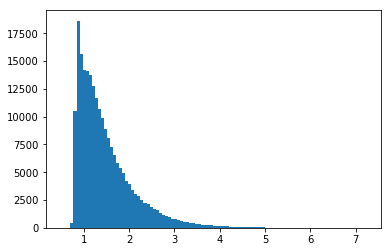

In [40]:
plt.hist(np.array(lst).mean(0).reshape([-1]),bins=100);

In [41]:
plt.plot(np.array(lst)[:,0,120]);

In [52]:
rawy[:,:,1688]

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float16)

In [65]:
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in [1688]:
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    yy_pred3=amodel.predict(ax,4096)[:,0].reshape(train_test.shape[:2])
print yy_pred3.shape
pickle.dump(yy_pred3,open(a.name+".pred",'wb'))

(54, 4100)


In [58]:
c=np.arange(60).reshape([3,4,5])

In [62]:
(c.reshape([-1,5]).reshape([3,4,5])==c).all()

True